In [1]:
from utils import prepare_dataframe

df = prepare_dataframe("merged.csv")
resulting_label_count = df['labels'].nunique()
df

labels
bug            17934
enhancement    16113
clean          15336
performance     5332
refactor        3320
Name: count, dtype: int64
labels
enhancement    15300
bug            15300
clean          15300
Name: count, dtype: int64


,full_repo_name,labels,patch,index
16780,apache/skywalking,enhancement,"@@ -142,4 +142,13 @@ public class StorageModul...",16780
17669,apache/skywalking,enhancement,"@@ -21,6 +21,7 @@\n import java.util.Map;\n im...",17669
39739,apache/netbeans,enhancement,"@@ -19,9 +19,8 @@\n package org.netbeans.modul...",39739
5509,apache/myfaces-tobago,enhancement,"@@ -26,6 +26,7 @@\n \n import jakarta.faces.co...",5509
3099,apache/cloudstack,enhancement,"@@ -42,14 +42,18 @@ public final class Libvirt...",3099
...,...,...,...,...
28870,apache/bookkeeper,clean,"@@ -245,6 +245,7 @@ void unsetSuccessAndSendWr...",28870
30713,apache/netbeans,clean,"@@ -36,7 +36,6 @@\n import org.eclipse.persist...",30713
24323,apache/pulsar,clean,"@@ -18,30 +18,29 @@\n */\n package org.apache...",24323
32419,apache/netbeans,clean,"@@ -77,7 +77,7 @@ public void initialize(Templ...",32419


In [45]:
embedding_directory = 'embeddings/GCB_Pooler_embeddings_patch_before_largewithcodedata_15300limit3label'
model_directory = 'models/two_pipelines_StScaler_pooler_6layers_invertednn_100epoch_batch_normalization.pth'

In [3]:
import pandas as pd
import torch

# One-hot encoding ile labels sütununu dönüştürme
df_encoded_labels = pd.get_dummies(df, columns=['labels'])
df_encoded_repo = pd.get_dummies(df, columns=['full_repo_name'])

# Özellikler ve etiketler
X_repo = df_encoded_repo.drop(columns=['labels','patch','index'])
X_repo = X_repo.astype(int)

# y = df_encoded.drop(columns=['content_before', 'content_after', 'tokens'])
y = df_encoded_labels.drop(columns=['patch', 'full_repo_name','index'])
y = y.astype(int) # convert it 0,1     instead of true, false 

df['label_tensor'] =[torch.tensor(row,dtype=torch.float32) for row in y.values] 
df['repo_name_tensor'] =[torch.tensor(row,dtype=torch.float32) for row in X_repo.values] 

df = df.drop(columns=['full_repo_name', 'labels','patch'])


print(df['label_tensor'][0] )
print(df['repo_name_tensor'][0] )
df

tensor([0., 0., 1.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


,index,label_tensor,repo_name_tensor
16780,16780,"[tensor(0.), tensor(0.), tensor(1.)]","[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
17669,17669,"[tensor(0.), tensor(0.), tensor(1.)]","[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
39739,39739,"[tensor(0.), tensor(0.), tensor(1.)]","[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
5509,5509,"[tensor(0.), tensor(0.), tensor(1.)]","[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3099,3099,"[tensor(0.), tensor(0.), tensor(1.)]","[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...
28870,28870,"[tensor(0.), tensor(1.), tensor(0.)]","[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
30713,30713,"[tensor(0.), tensor(1.), tensor(0.)]","[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
24323,24323,"[tensor(0.), tensor(1.), tensor(0.)]","[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
32419,32419,"[tensor(0.), tensor(1.), tensor(0.)]","[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [4]:
from utils import load_embeddings_from_directory_for_df
import pandas as pd

df = load_embeddings_from_directory_for_df(directory_path=embedding_directory,df=df)


  0%|          | 0/45900 [00:00<?, ?it/s]

In [5]:
from sklearn.model_selection import train_test_split

X_index = df[['index']]
# Split the code data into test, train and validation sets
X_index_train, X_index_test = train_test_split(X_index, test_size=0.3, random_state=42) #random_state: 0,3074,42
X_index_test, X_index_val = train_test_split(X_index_test, test_size=0.5, random_state=42)

In [6]:
import gc
import torch

df_train = df[df['index'].isin(X_index_train['index'].values)].reset_index(drop=True)
df_val = df[df['index'].isin(X_index_val['index'].values)].reset_index(drop=True)
df_test = df[df['index'].isin(X_index_test['index'].values)].reset_index(drop=True)

torch.cuda.empty_cache()

df_train

,index,label_tensor,repo_name_tensor,embedding
0,39739,"[tensor(0.), tensor(0.), tensor(1.)]","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(-0.4503), tensor(0.2574), tensor(0.283..."
1,5509,"[tensor(0.), tensor(0.), tensor(1.)]","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(-0.4471), tensor(0.1839), tensor(0.028..."
2,45680,"[tensor(0.), tensor(0.), tensor(1.)]","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(-0.1267), tensor(-0.1298), tensor(0.08..."
3,827,"[tensor(0.), tensor(0.), tensor(1.)]","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(-0.2117), tensor(0.1112), tensor(-0.00..."
4,53472,"[tensor(0.), tensor(0.), tensor(1.)]","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(-0.4323), tensor(0.0370), tensor(0.130..."
...,...,...,...,...
32125,28870,"[tensor(0.), tensor(1.), tensor(0.)]","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(-0.1593), tensor(0.0117), tensor(0.037..."
32126,30713,"[tensor(0.), tensor(1.), tensor(0.)]","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(-0.0774), tensor(0.2843), tensor(0.145..."
32127,24323,"[tensor(0.), tensor(1.), tensor(0.)]","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(-0.4991), tensor(0.2270), tensor(0.189..."
32128,32419,"[tensor(0.), tensor(1.), tensor(0.)]","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(-0.0915), tensor(0.0837), tensor(0.112..."


In [7]:
from torch.utils.data import DataLoader, Dataset
from utils import load_embedding_from_directory

# Custom Dataset Class to handle the dataframe
class CodeDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.id_list = df['index'].values 

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
    
        index = self.id_list[idx]  

        tensor_3d = self.df.loc[self.df['index'] == index, 'embedding'].iloc[0]
        repo_name_tensor = self.df.loc[self.df['index'] == index, 'repo_name_tensor'].iloc[0]
        label_tensor = self.df.loc[self.df['index'] == index, 'label_tensor'].iloc[0]
        
        #print(f"{repo_name_tensor.shape} {tensor_3d.shape} {label_tensor.shape}")
        #print("-------------------------------")
        
        #Flattening
        #embedding = torch.flatten(tensor_3d)
        embedding = tensor_3d
        return embedding, label_tensor, repo_name_tensor, index


In [8]:
# Create DataLoader

# Creating a DataLoader
def create_dataloader(df, batch_size=32, shuffle=True):
    dataset = CodeDataset(df)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

batch_size = 128
test_loader = create_dataloader(df=df_test, batch_size=batch_size)
train_loader = create_dataloader(df=df_train, batch_size=batch_size)
val_loader = create_dataloader(df=df_val,batch_size=batch_size)

full_loader_for_scaler = create_dataloader(df=df, batch_size=512)

In [9]:
from sklearn.preprocessing import StandardScaler
import tqdm

scaler = StandardScaler()

for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(full_loader_for_scaler):
    scaler.partial_fit(batch_X)

/tmp/ipykernel_2395608/796712526.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(full_loader_for_scaler):


  0%|          | 0/90 [00:00<?, ?it/s]

In [10]:
import joblib

# Save scaler into file
joblib.dump(scaler, 'scalers/scaler_pooler_3labels_15300.pkl')

['scalers/scaler_pooler_3labels_15300.pkl']

In [11]:
import joblib

# Load scaler from file
scaler = joblib.load('scalers/scaler_pooler_3labels_15300.pkl')

In [12]:
# import torch.nn as nn

# # Define the ANN model
# class SinglePipelineCodeDiffNN(nn.Module):
#     def __init__(self, code_input_size, hidden_sizes, output_size, dropout_rate=0.05):
#         super(SinglePipelineCodeDiffNN, self).__init__()
        
#         # Pipeline for code embeddings
#         self.code_fc1 = nn.Linear(code_input_size, hidden_sizes[0])
#         self.code_relu1 = nn.ReLU()
#         self.code_dropout1 = nn.Dropout(dropout_rate)
        
#         self.code_fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
#         self.code_relu2 = nn.ReLU()
#         self.code_dropout2 = nn.Dropout(dropout_rate)

#         self.code_fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
#         self.code_relu3 = nn.ReLU()
#         self.code_dropout3 = nn.Dropout(dropout_rate)

#         self.code_fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
#         self.code_relu4 = nn.ReLU()
#         self.code_dropout4 = nn.Dropout(dropout_rate)

#         self.code_fc5 = nn.Linear(hidden_sizes[3], hidden_sizes[4])
#         self.code_relu5 = nn.ReLU()
        
#         self.code_fc_out = nn.Linear(hidden_sizes[4], output_size)

        
#     def forward(self, code_x):
#         # Process code embeddings
#         code_x = self.code_fc1(code_x)
#         code_x = self.code_relu1(code_x)
#         code_x = self.code_dropout1(code_x)
        
#         code_x = self.code_fc2(code_x)
#         code_x = self.code_relu2(code_x)
#         code_x = self.code_dropout2(code_x)

#         code_x = self.code_fc3(code_x)
#         code_x = self.code_relu3(code_x)
#         code_x = self.code_dropout3(code_x)

#         code_x = self.code_fc4(code_x)
#         code_x = self.code_relu4(code_x)
#         code_x = self.code_dropout4(code_x)

#         code_x = self.code_fc5(code_x)
#         code_x = self.code_relu5(code_x)

#         # Final output
#         output = self.code_fc_out(code_x)
#         return output


In [59]:
import torch.nn as nn

# Define the ANN model
class CodeDiffNN(nn.Module):
    def __init__(self, code_input_size, repo_input_size, hidden_sizes_embedding_pipeline,hidden_sizes_reponame_pipeline,hidden_sizes_merged_pipeline, output_size, dropout_rate):
        super(CodeDiffNN, self).__init__()
        
        # Pipeline for code embeddings
        self.code_fc1 = nn.Linear(code_input_size, hidden_sizes_embedding_pipeline[0])
        self.code_bn1 = nn.BatchNorm1d(hidden_sizes_embedding_pipeline[0])
        self.code_relu1 = nn.ReLU()
        self.code_dropout1 = nn.Dropout(dropout_rate)
        
        self.code_fc2 = nn.Linear(hidden_sizes_embedding_pipeline[0], hidden_sizes_embedding_pipeline[1])
        self.code_bn2 = nn.BatchNorm1d(hidden_sizes_embedding_pipeline[1])
        self.code_relu2 = nn.ReLU()
        self.code_dropout2 = nn.Dropout(dropout_rate)
        
        self.code_fc3 = nn.Linear(hidden_sizes_embedding_pipeline[1], hidden_sizes_embedding_pipeline[2])
        self.code_bn3 = nn.BatchNorm1d(hidden_sizes_embedding_pipeline[2])
        self.code_relu3 = nn.ReLU()
        self.code_dropout3 = nn.Dropout(dropout_rate)  
        
        
        # Pipeline for repo names
        self.repo_fc1 = nn.Linear(repo_input_size, hidden_sizes_reponame_pipeline[0])
        self.repo_bn1 = nn.BatchNorm1d(hidden_sizes_reponame_pipeline[0])
        self.repo_relu1 = nn.ReLU()
        self.repo_dropout1 = nn.Dropout(dropout_rate)
        
        self.repo_fc2 = nn.Linear(hidden_sizes_reponame_pipeline[0], hidden_sizes_reponame_pipeline[1])
        self.repo_bn2 = nn.BatchNorm1d(hidden_sizes_reponame_pipeline[1])
        self.repo_relu2 = nn.ReLU()
        self.repo_dropout2 = nn.Dropout(dropout_rate)

        
        # Combining the outputs of both pipelines
        combined_input_size = hidden_sizes_embedding_pipeline[2] + hidden_sizes_reponame_pipeline[1]   # Since we're combining two pipelines
        self.combined_fc1 = nn.Linear(combined_input_size, hidden_sizes_merged_pipeline[0])
        self.combined_bn1 = nn.BatchNorm1d(hidden_sizes_merged_pipeline[0])
        self.combined_relu1 = nn.ReLU()
        self.combined_dropout1 = nn.Dropout(dropout_rate)

        self.combined_fc2  = nn.Linear(hidden_sizes_merged_pipeline[0], hidden_sizes_merged_pipeline[1])
        self.combined_bn2 = nn.BatchNorm1d(hidden_sizes_merged_pipeline[1])
        self.combined_relu2  = nn.ReLU()
        self.combined_dropout2 = nn.Dropout(dropout_rate)
        
        self.combined_fc3  = nn.Linear(hidden_sizes_merged_pipeline[1], hidden_sizes_merged_pipeline[2])
        self.combined_bn3 = nn.BatchNorm1d(hidden_sizes_merged_pipeline[2])
        self.combined_relu3  = nn.ReLU()
        self.combined_dropout3 = nn.Dropout(dropout_rate)
        
        self.combined_fc4  = nn.Linear(hidden_sizes_merged_pipeline[2], hidden_sizes_merged_pipeline[3])
        self.combined_bn4 = nn.BatchNorm1d(hidden_sizes_merged_pipeline[3])
        self.combined_relu4  = nn.ReLU()
        self.combined_dropout4 = nn.Dropout(dropout_rate)

        # Output layer
        self.fc_out = nn.Linear(hidden_sizes_merged_pipeline[3], output_size)
        
    def forward(self, code_x, repo_x):
        # Process code embeddings
        code_x = self.code_fc1(code_x)
        code_x = self.code_bn1(code_x)
        code_x = self.code_relu1(code_x)
        code_x = self.code_dropout1(code_x)
        
        code_x = self.code_fc2(code_x)
        code_x = self.code_bn2(code_x)
        code_x = self.code_relu2(code_x)
        code_x = self.code_dropout2(code_x)
        
        code_x = self.code_fc3(code_x)
        code_x = self.code_bn3(code_x)
        code_x = self.code_relu3(code_x)
        code_x = self.code_dropout3(code_x)
        
        # Process repo names
        repo_x = self.repo_fc1(repo_x)
        repo_x = self.repo_bn1(repo_x)
        repo_x = self.repo_relu1(repo_x)
        repo_x = self.repo_dropout1(repo_x)
        
        repo_x = self.repo_fc2(repo_x)
        repo_x = self.repo_bn2(repo_x)
        repo_x = self.repo_relu2(repo_x)
        repo_x = self.repo_dropout2(repo_x)
        
        # Combine both outputs
        combined_x = torch.cat((code_x, repo_x), dim=1)
        
        # Process the combined output
        combined_x = self.combined_fc1(combined_x)
        combined_x = self.combined_bn1(combined_x)
        combined_x = self.combined_relu1(combined_x)
        combined_x = self.combined_dropout1(combined_x)

        combined_x = self.combined_fc2(combined_x)
        combined_x = self.combined_bn2(combined_x)
        combined_x = self.combined_relu2(combined_x)
        combined_x = self.combined_dropout2(combined_x)
        
        combined_x = self.combined_fc3(combined_x)
        combined_x = self.combined_bn3(combined_x)
        combined_x = self.combined_relu3(combined_x)
        combined_x = self.combined_dropout3(combined_x)
        
        combined_x = self.combined_fc4(combined_x)
        combined_x = self.combined_bn4(combined_x)
        combined_x = self.combined_relu4(combined_x)
        combined_x = self.combined_dropout4(combined_x)
        
        # Final output
        output = self.fc_out(combined_x)
        return output


In [23]:
# import torch.nn as nn

# # Define the ANN model
# class CodeDiffNN(nn.Module):
#     def __init__(self, code_embedding_dim, repo_input_size, hidden_sizes, output_size, dropout_rate=0.001):
#         super(CodeDiffNN, self).__init__()
        
#         # Pipeline for code embeddings (Conv2D for 2D input)
#         # Set in_channels to the embedding dimension (e.g., 768)
#         # Increase out_channels to better handle high-dimensional inputs
#         self.code_conv1 = nn.Conv2d(in_channels=code_embedding_dim, out_channels=128, kernel_size=3, padding=1)
#         self.code_relu1 = nn.ReLU()
#         self.code_dropout1 = nn.Dropout(dropout_rate)
        
#         self.code_conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
#         self.code_relu2 = nn.ReLU()
#         self.code_dropout2 = nn.Dropout(dropout_rate)

#         # Assuming a fixed input size for flattening (adjust this based on the input size and conv layer operations)
#         self.code_flatten = nn.Flatten()

#         # Flattened output from conv layers should map to hidden_sizes[1]
#         self.code_fc = nn.Linear(256*512, hidden_sizes[1])  # Modify based on input dimensions
        
#         # Pipeline for repo names (still using Linear layers for 1D input)
#         self.repo_fc1 = nn.Linear(repo_input_size, hidden_sizes[0])
#         self.repo_relu1 = nn.ReLU()
#         self.repo_dropout1 = nn.Dropout(dropout_rate)
        
#         self.repo_fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
#         self.repo_relu2 = nn.ReLU()
#         self.repo_dropout2 = nn.Dropout(dropout_rate)
        
#         # Combining the outputs of both pipelines
#         combined_input_size = hidden_sizes[1] * 2  # Since we're combining two pipelines
#         self.fc_combined = nn.Linear(combined_input_size, hidden_sizes[2])
#         self.relu_combined = nn.ReLU()
#         self.dropout_combined = nn.Dropout(dropout_rate)

#         # Output layer
#         self.fc_out = nn.Linear(hidden_sizes[2], output_size)
        
#     def forward(self, code_x, repo_x):
#         # Reformat input
#         # [batch_size, sequence_length, embedding_dim] -> [batch_size, embedding_dim, sequence_length, 1]
#         code_x = code_x.permute(0, 2, 1).unsqueeze(-1)
        
#         # Process code embeddings (2D input)
#         code_x = self.code_conv1(code_x)
#         code_x = self.code_relu1(code_x)
#         code_x = self.code_dropout1(code_x)
        
#         code_x = self.code_conv2(code_x)
#         code_x = self.code_relu2(code_x)
#         code_x = self.code_dropout2(code_x)
        
#         # Flatten the output from the conv layers before the fully connected layer
#         code_x = self.code_flatten(code_x)
#         code_x = self.code_fc(code_x)
        
#         # Process repo names (1D input)
#         repo_x = self.repo_fc1(repo_x)
#         repo_x = self.repo_relu1(repo_x)
#         repo_x = self.repo_dropout1(repo_x)
        
#         repo_x = self.repo_fc2(repo_x)
#         repo_x = self.repo_relu2(repo_x)
#         repo_x = self.repo_dropout2(repo_x)
        
#         # Combine both outputs
#         combined_x = torch.cat((code_x, repo_x), dim=1)
        
#         # Process the combined output
#         combined_x = self.fc_combined(combined_x)
#         combined_x = self.relu_combined(combined_x)
#         combined_x = self.dropout_combined(combined_x)
        
#         # Final output
#         output = self.fc_out(combined_x)
#         return output

In [46]:
import torch.optim as optim
# Define model parameters

code_embedding_dim = df_train['embedding'][5].shape[0]

repo_input_size = len(df_train['repo_name_tensor'][0])
#hidden_sizes = [1024, 512, 256, 128]
hidden_sizes_embedding_pipeline = [1024, 2048, 4096]
hidden_sizes_reponame_pipeline = [512, 1024]
hidden_sizes_merged_pipeline = [2048, 1024, 512, 256]
output_size = resulting_label_count
dropout_rate = 0.05

device = "cuda:0"
model = CodeDiffNN(code_embedding_dim, repo_input_size, hidden_sizes_embedding_pipeline,hidden_sizes_reponame_pipeline,hidden_sizes_merged_pipeline, output_size, dropout_rate).to(device)
# model = SinglePipelineCodeDiffNN(code_embedding_dim, hidden_sizes, output_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Decrease learning rate automatically on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=400, factor=0.1, verbose=True)

In [47]:
print(resulting_label_count)
print(code_embedding_dim)
torch.cuda.empty_cache()

3
768


In [48]:
# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
    # labels_1d = torch.argmax(labels, dim=1) # turn into 1D tensor
    correct = (predicted == labels).sum().item()
    accuracy = correct / labels.size(0)  # Accuracy = number of correct predictions / total number of samples
    return accuracy

In [49]:
import tqdm

def train_with_data_loader(model,loader):
    
    running_loss = 0.0
    running_accuracy = 0.0
    
    for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):
        
        batch_X = scaler.transform(batch_X)
        batch_X = torch.tensor(batch_X,dtype=torch.float32)
        
        # Forward pass        
        batch_y = batch_y.to(device)
        batch_X = batch_X.to(device)
        batch_X_repo = batch_X_repo.to(device)
        
        batch_y = torch.argmax(batch_y, dim=1)

        # outputs = model(batch_X)
        outputs = model(batch_X, batch_X_repo)
        loss = criterion(outputs, batch_y)
    
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        accuracy = calculate_accuracy(outputs, batch_y)
        
        # Update running loss and accuracy
        running_loss += loss.item()
        running_accuracy += accuracy
        
        
    val_loss = running_loss / len(loader)
    val_accuracy = running_accuracy / len(loader)
    
    return val_loss, val_accuracy

In [50]:
def evaluate_with_data_loader(model,loader):
    
    running_loss = 0.0
    running_accuracy = 0.0
    
    for batch_X, batch_y, batch_X_repo, idx in loader:
        
        batch_X = scaler.transform(batch_X)
        batch_X = torch.tensor(batch_X,dtype=torch.float32)
        
        # Forward pass
        batch_y = batch_y.to(device)
        batch_X = batch_X.to(device)
        batch_X_repo = batch_X_repo.to(device)
        
        batch_y = torch.argmax(batch_y, dim=1)

        outputs = model(batch_X, batch_X_repo)
        # outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Calculate accuracy
        accuracy = calculate_accuracy(outputs, batch_y)
        
        # Update running loss and accuracy
        running_loss += loss.item()
        running_accuracy += accuracy
        
        
    val_loss = running_loss / len(loader)
    val_accuracy = running_accuracy / len(loader)
    
    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)
    
    return val_loss, val_accuracy

In [51]:
def test_with_data_loader(model,loader):
    
    running_loss = 0.0
    running_accuracy = 0.0
    predicted_y = []
    y = []
    
    for batch_X, batch_y, batch_X_repo, idx in loader:
        
        batch_X = scaler.transform(batch_X)
        batch_X = torch.tensor(batch_X,dtype=torch.float32)

        # Forward pass
        batch_y = batch_y.to(device)
        batch_X = batch_X.to(device)
        batch_X_repo = batch_X_repo.to(device)
        
        # index encoding
        batch_y_1D = torch.argmax(batch_y, dim=1)

        outputs = model(batch_X, batch_X_repo)
        # outputs = model(batch_X)
        loss = criterion(outputs, batch_y_1D)
        
        # Calculate accuracy
        accuracy = calculate_accuracy(outputs, batch_y_1D)
        
        # Update running loss and accuracy
        running_loss += loss.item()
        running_accuracy += accuracy

        predicted_y.append(outputs)
        y.append(batch_y)
        
    test_loss = running_loss / len(loader)
    test_accuracy = running_accuracy / len(loader)
    
    return test_loss, test_accuracy, torch.cat(predicted_y, dim=0), torch.cat(y, dim=0)

In [52]:
import copy
import tqdm

# Train the model

# Initialize variables to track the best model and best accuracy
best_accuracy = 0.0

num_epochs = 100

for epoch in tqdm.tqdm_notebook(range(num_epochs)):
    model.train()  # Set the model to training mode
    
    # Print average loss and accuracy for the epoch
    avg_loss,avg_accuracy = train_with_data_loader(model= model,loader= train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

    # Evaluate on validation data
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient computation for validation
        val_loss,val_accuracy = evaluate_with_data_loader(model=model,loader=val_loader)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
    # Check if the current model has the best validation accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), model_directory)
    



/tmp/ipykernel_2395608/922264242.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [1/100], Loss: 0.6327, Accuracy: 0.7039
Validation Loss: 0.5709, Validation Accuracy: 0.7344


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [2/100], Loss: 0.5114, Accuracy: 0.7656
Validation Loss: 0.5012, Validation Accuracy: 0.7704


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [3/100], Loss: 0.4716, Accuracy: 0.7878
Validation Loss: 0.5011, Validation Accuracy: 0.7768


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [4/100], Loss: 0.4336, Accuracy: 0.8056
Validation Loss: 0.4864, Validation Accuracy: 0.7863


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [5/100], Loss: 0.4068, Accuracy: 0.8185
Validation Loss: 0.4845, Validation Accuracy: 0.7851


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [6/100], Loss: 0.3777, Accuracy: 0.8344
Validation Loss: 0.4689, Validation Accuracy: 0.7965


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [7/100], Loss: 0.3581, Accuracy: 0.8462
Validation Loss: 0.4917, Validation Accuracy: 0.7852


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [8/100], Loss: 0.3257, Accuracy: 0.8610
Validation Loss: 0.5018, Validation Accuracy: 0.7978


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [9/100], Loss: 0.3009, Accuracy: 0.8717
Validation Loss: 0.5085, Validation Accuracy: 0.7888


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [10/100], Loss: 0.2875, Accuracy: 0.8780
Validation Loss: 0.5089, Validation Accuracy: 0.8076


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [11/100], Loss: 0.2478, Accuracy: 0.8972
Validation Loss: 0.5522, Validation Accuracy: 0.8103


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [12/100], Loss: 0.2485, Accuracy: 0.9041
Validation Loss: 0.5519, Validation Accuracy: 0.8061


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [13/100], Loss: 0.2172, Accuracy: 0.9127
Validation Loss: 0.5699, Validation Accuracy: 0.8109


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [14/100], Loss: 0.2206, Accuracy: 0.9129
Validation Loss: 0.5896, Validation Accuracy: 0.8104


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [15/100], Loss: 0.1986, Accuracy: 0.9161
Validation Loss: 0.5961, Validation Accuracy: 0.8015


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [16/100], Loss: 0.2060, Accuracy: 0.9251
Validation Loss: 0.6230, Validation Accuracy: 0.8120


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [17/100], Loss: 0.1673, Accuracy: 0.9322
Validation Loss: 0.6129, Validation Accuracy: 0.8063


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [18/100], Loss: 0.1715, Accuracy: 0.9325
Validation Loss: 0.6580, Validation Accuracy: 0.8130


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [19/100], Loss: 0.1763, Accuracy: 0.9362
Validation Loss: 0.6912, Validation Accuracy: 0.8095


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [20/100], Loss: 0.1530, Accuracy: 0.9383
Validation Loss: 0.7137, Validation Accuracy: 0.8153


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [21/100], Loss: 0.1423, Accuracy: 0.9433
Validation Loss: 0.7262, Validation Accuracy: 0.8200


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [22/100], Loss: 0.1645, Accuracy: 0.9435
Validation Loss: 0.7189, Validation Accuracy: 0.8192


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [23/100], Loss: 0.1542, Accuracy: 0.9480
Validation Loss: 0.7031, Validation Accuracy: 0.8143


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [24/100], Loss: 0.1140, Accuracy: 0.9554
Validation Loss: 0.7700, Validation Accuracy: 0.8191


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [25/100], Loss: 0.1485, Accuracy: 0.9541
Validation Loss: 0.7290, Validation Accuracy: 0.8248


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [26/100], Loss: 0.1074, Accuracy: 0.9592
Validation Loss: 0.7149, Validation Accuracy: 0.8225


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [27/100], Loss: 0.0967, Accuracy: 0.9613
Validation Loss: 0.7572, Validation Accuracy: 0.8179


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [28/100], Loss: 0.1252, Accuracy: 0.9609
Validation Loss: 0.7489, Validation Accuracy: 0.8293


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [29/100], Loss: 0.0923, Accuracy: 0.9685
Validation Loss: 0.7809, Validation Accuracy: 0.8268


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [30/100], Loss: 0.0857, Accuracy: 0.9661
Validation Loss: 0.8025, Validation Accuracy: 0.8261


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [31/100], Loss: 0.0805, Accuracy: 0.9671
Validation Loss: 0.8227, Validation Accuracy: 0.8294


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [32/100], Loss: 0.0796, Accuracy: 0.9702
Validation Loss: 0.7841, Validation Accuracy: 0.8225


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [33/100], Loss: 0.0753, Accuracy: 0.9706
Validation Loss: 0.8448, Validation Accuracy: 0.8211


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [34/100], Loss: 0.1026, Accuracy: 0.9706
Validation Loss: 0.8677, Validation Accuracy: 0.8232


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [35/100], Loss: 0.0779, Accuracy: 0.9710
Validation Loss: 0.8866, Validation Accuracy: 0.8276


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [36/100], Loss: 0.0746, Accuracy: 0.9714
Validation Loss: 0.8656, Validation Accuracy: 0.8213


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [37/100], Loss: 0.1095, Accuracy: 0.9700
Validation Loss: 0.8705, Validation Accuracy: 0.8235


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [38/100], Loss: 0.0774, Accuracy: 0.9729
Validation Loss: 0.8422, Validation Accuracy: 0.8296


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [39/100], Loss: 0.0632, Accuracy: 0.9764
Validation Loss: 0.8965, Validation Accuracy: 0.8245


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [40/100], Loss: 0.0680, Accuracy: 0.9743
Validation Loss: 0.9711, Validation Accuracy: 0.8263


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [41/100], Loss: 0.0791, Accuracy: 0.9761
Validation Loss: 0.8787, Validation Accuracy: 0.8280


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [42/100], Loss: 0.0719, Accuracy: 0.9752
Validation Loss: 0.8497, Validation Accuracy: 0.8291


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [43/100], Loss: 0.0582, Accuracy: 0.9782
Validation Loss: 0.8811, Validation Accuracy: 0.8270


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [44/100], Loss: 0.0708, Accuracy: 0.9747
Validation Loss: 0.8272, Validation Accuracy: 0.8297


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [45/100], Loss: 0.0659, Accuracy: 0.9751
Validation Loss: 0.8553, Validation Accuracy: 0.8258


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [46/100], Loss: 0.0691, Accuracy: 0.9766
Validation Loss: 0.8835, Validation Accuracy: 0.8238


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [47/100], Loss: 0.0738, Accuracy: 0.9750
Validation Loss: 0.9143, Validation Accuracy: 0.8295


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [48/100], Loss: 0.0691, Accuracy: 0.9768
Validation Loss: 0.9604, Validation Accuracy: 0.8241


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [49/100], Loss: 0.0532, Accuracy: 0.9807
Validation Loss: 0.8888, Validation Accuracy: 0.8259


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [50/100], Loss: 0.0690, Accuracy: 0.9777
Validation Loss: 0.9426, Validation Accuracy: 0.8237


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [51/100], Loss: 0.0661, Accuracy: 0.9786
Validation Loss: 0.9171, Validation Accuracy: 0.8294


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [52/100], Loss: 0.0748, Accuracy: 0.9777
Validation Loss: 0.8753, Validation Accuracy: 0.8292


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [53/100], Loss: 0.0824, Accuracy: 0.9794
Validation Loss: 0.9076, Validation Accuracy: 0.8276


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [54/100], Loss: 0.0703, Accuracy: 0.9774
Validation Loss: 0.8966, Validation Accuracy: 0.8272


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [55/100], Loss: 0.0800, Accuracy: 0.9779
Validation Loss: 0.9071, Validation Accuracy: 0.8295


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [56/100], Loss: 0.0515, Accuracy: 0.9813
Validation Loss: 0.8400, Validation Accuracy: 0.8240


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [57/100], Loss: 0.0499, Accuracy: 0.9816
Validation Loss: 0.8431, Validation Accuracy: 0.8293


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [58/100], Loss: 0.0487, Accuracy: 0.9809
Validation Loss: 0.8777, Validation Accuracy: 0.8301


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [59/100], Loss: 0.0648, Accuracy: 0.9781
Validation Loss: 0.8648, Validation Accuracy: 0.8192


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [60/100], Loss: 0.0521, Accuracy: 0.9821
Validation Loss: 0.8840, Validation Accuracy: 0.8277


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [61/100], Loss: 0.0625, Accuracy: 0.9791
Validation Loss: 0.8294, Validation Accuracy: 0.8264


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [62/100], Loss: 0.0495, Accuracy: 0.9812
Validation Loss: 0.8354, Validation Accuracy: 0.8260


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [63/100], Loss: 0.0735, Accuracy: 0.9795
Validation Loss: 0.8875, Validation Accuracy: 0.8265


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [64/100], Loss: 0.0561, Accuracy: 0.9808
Validation Loss: 0.8711, Validation Accuracy: 0.8330


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [65/100], Loss: 0.0474, Accuracy: 0.9818
Validation Loss: 0.9184, Validation Accuracy: 0.8293


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [66/100], Loss: 0.0689, Accuracy: 0.9791
Validation Loss: 0.8764, Validation Accuracy: 0.8212


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [67/100], Loss: 0.0472, Accuracy: 0.9815
Validation Loss: 0.8620, Validation Accuracy: 0.8295


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [68/100], Loss: 0.0585, Accuracy: 0.9814
Validation Loss: 0.8925, Validation Accuracy: 0.8257


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [69/100], Loss: 0.0589, Accuracy: 0.9780
Validation Loss: 0.9573, Validation Accuracy: 0.8278


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [70/100], Loss: 0.0701, Accuracy: 0.9803
Validation Loss: 0.8960, Validation Accuracy: 0.8250


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [71/100], Loss: 0.0513, Accuracy: 0.9816
Validation Loss: 0.8917, Validation Accuracy: 0.8236


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [72/100], Loss: 0.0678, Accuracy: 0.9764
Validation Loss: 0.8580, Validation Accuracy: 0.8262


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [73/100], Loss: 0.0596, Accuracy: 0.9777
Validation Loss: 0.9265, Validation Accuracy: 0.8271


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [74/100], Loss: 0.0524, Accuracy: 0.9817
Validation Loss: 0.8637, Validation Accuracy: 0.8238


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [75/100], Loss: 0.0535, Accuracy: 0.9796
Validation Loss: 0.9022, Validation Accuracy: 0.8268


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [76/100], Loss: 0.0640, Accuracy: 0.9776
Validation Loss: 0.9106, Validation Accuracy: 0.8280


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [77/100], Loss: 0.0503, Accuracy: 0.9826
Validation Loss: 0.9040, Validation Accuracy: 0.8275


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [78/100], Loss: 0.0704, Accuracy: 0.9792
Validation Loss: 0.9077, Validation Accuracy: 0.8297


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [79/100], Loss: 0.0503, Accuracy: 0.9821
Validation Loss: 0.8978, Validation Accuracy: 0.8286


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [80/100], Loss: 0.0684, Accuracy: 0.9774
Validation Loss: 0.8956, Validation Accuracy: 0.8225


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [81/100], Loss: 0.0717, Accuracy: 0.9799
Validation Loss: 0.9120, Validation Accuracy: 0.8257


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [82/100], Loss: 0.0636, Accuracy: 0.9785
Validation Loss: 0.9505, Validation Accuracy: 0.8273


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [83/100], Loss: 0.0526, Accuracy: 0.9803
Validation Loss: 0.9253, Validation Accuracy: 0.8211


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [84/100], Loss: 0.0703, Accuracy: 0.9798
Validation Loss: 0.9248, Validation Accuracy: 0.8251


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [85/100], Loss: 0.0526, Accuracy: 0.9810
Validation Loss: 0.8995, Validation Accuracy: 0.8237


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [86/100], Loss: 0.0692, Accuracy: 0.9771
Validation Loss: 0.9104, Validation Accuracy: 0.8232


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [87/100], Loss: 0.0518, Accuracy: 0.9807
Validation Loss: 0.9427, Validation Accuracy: 0.8275


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [88/100], Loss: 0.0572, Accuracy: 0.9793
Validation Loss: 0.9011, Validation Accuracy: 0.8268


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [89/100], Loss: 0.0562, Accuracy: 0.9786
Validation Loss: 0.9043, Validation Accuracy: 0.8247


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [90/100], Loss: 0.0649, Accuracy: 0.9767
Validation Loss: 0.9079, Validation Accuracy: 0.8269


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [91/100], Loss: 0.0547, Accuracy: 0.9790
Validation Loss: 0.9404, Validation Accuracy: 0.8268


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [92/100], Loss: 0.0560, Accuracy: 0.9798
Validation Loss: 0.8754, Validation Accuracy: 0.8264


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [93/100], Loss: 0.0732, Accuracy: 0.9761
Validation Loss: 0.9535, Validation Accuracy: 0.8222


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [94/100], Loss: 0.0665, Accuracy: 0.9773
Validation Loss: 0.9339, Validation Accuracy: 0.8284


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [95/100], Loss: 0.0646, Accuracy: 0.9776
Validation Loss: 0.9746, Validation Accuracy: 0.8304


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [96/100], Loss: 0.0511, Accuracy: 0.9809
Validation Loss: 0.9512, Validation Accuracy: 0.8285


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [97/100], Loss: 0.0632, Accuracy: 0.9787
Validation Loss: 0.8922, Validation Accuracy: 0.8277


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [98/100], Loss: 0.0677, Accuracy: 0.9776
Validation Loss: 0.9428, Validation Accuracy: 0.8257


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [99/100], Loss: 0.0505, Accuracy: 0.9817
Validation Loss: 0.9011, Validation Accuracy: 0.8244


/tmp/ipykernel_2395608/2221030542.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_X, batch_y, batch_X_repo, idx in tqdm.tqdm_notebook(loader):


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [100/100], Loss: 0.0649, Accuracy: 0.9792
Validation Loss: 0.8469, Validation Accuracy: 0.8272


In [53]:
# Load model from file
model = CodeDiffNN(code_embedding_dim, repo_input_size, hidden_sizes_embedding_pipeline,hidden_sizes_reponame_pipeline, hidden_sizes_merged_pipeline, output_size, dropout_rate).to(device)
model.load_state_dict(torch.load(model_directory))

<All keys matched successfully>

In [56]:
with torch.no_grad():
    # Load best model from previous training cycle

    model.eval()
    test_loss,test_accuracy,test_outputs,y_test = test_with_data_loader(model=model,loader=test_loader)
    
    print(f'Accuracy on test data: {test_accuracy:.4f}')
    print(test_outputs.shape)

Accuracy on test data: 0.8301
torch.Size([6885, 3])


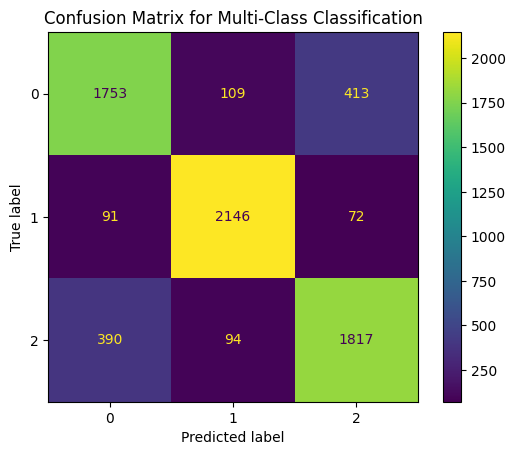

[1 1 1 ... 2 1 2]
[1 1 1 ... 0 1 2]


In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

_, predicted = torch.max(test_outputs.detach().cpu(), 1)  # Get the index of the max log-probability
labels_1d = torch.argmax(y_test, dim=1).cpu() # turn into 1D tensor

# Convert to numpy arrays
y_test_np = labels_1d.numpy()
predicted_np = predicted.numpy()

# Compute confusion matrix
cm = confusion_matrix(y_test_np, predicted_np)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix for Multi-Class Classification')
plt.show()

print(predicted_np)
print(y_test_np)

In [ ]:
import gc
# Free up GPU memory (testing)
print(f"Cached GPU memory before: {torch.cuda.memory_reserved()} bytes")
del model
del test_outputs
del y_test
del predicted
del labels_1d
del val_loader, test_loader, train_loader
del cm
gc.collect()
torch.cuda.empty_cache()
print(f"Cached GPU memory after: {torch.cuda.memory_reserved()} bytes")